In [12]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

import os, sys

# Relative paths
dirname = os.path.dirname
sep = os.sep

ml_folder = dirname(os.getcwd())
sys.path.append(ml_folder)

from src.utils import mining_data_tb as md
from src.utils import visualization_tb as vi

import warnings

warnings.filterwarnings("ignore")

In [13]:
# Variables' names data
vardata = md.variables_data()
var_data_path = "data" + sep + "6_variables" + sep + "0_final_variables.csv"

vardata.var_data(2, var_data_path)

# Full data
# Object
data = md.dataset()

# Loading data
data.load_data(0, ["1_demographics", "2_dietary", "3_examination", "4_laboratory", "5_questionnaire"])

# Cleanining duplicated columns
columns_correction = {
            "WTDRD1_x" : "WTDRD1",
            "WTDR2D_x" : "WTDR2D",
            "DRABF_x" : "DRABF",
            "DRDINT_x" : "DRDINT",
            "WTSAF2YR_x" : "WTSAF2YR",
            "LBXHCT_x" : "LBXHCT"
        }
data.clean_columns(columns_correction)

# Adding the heart_disease column
data.heart_disease()

# Picking the columns I want to use
features = ["MCQ010", "RIAGENDR", "RIDAGEYR", "DR1TCHOL", "DR1TTFAT", "DR1TSFAT", "DR1TSUGR", "DR2TCHOL", "DR2TTFAT", "DR2TSFAT", "DR2TSUGR", "BPXDI1", "BPXSY1", "BMXWT", "DXDTOPF", "BMXWAIST", "LBXTR", "LBXTC", "LBXSGL"]

data.filter_columns(features)

df = data.df

In [14]:
df = data.df
df = df[df.MCQ010 != 9]
df.MCQ010 = df.MCQ010.replace(2, 0)
df = df.drop(["LBXTR", "DXDTOPF"], axis = 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13472 entries, 83732 to 102956
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ010    13472 non-null  float64
 1   RIAGENDR  13472 non-null  int64  
 2   RIDAGEYR  13472 non-null  int64  
 3   DR1TCHOL  13472 non-null  float64
 4   DR1TTFAT  13472 non-null  float64
 5   DR1TSFAT  13472 non-null  float64
 6   DR1TSUGR  13472 non-null  float64
 7   DR2TCHOL  13472 non-null  float64
 8   DR2TTFAT  13472 non-null  float64
 9   DR2TSFAT  13472 non-null  float64
 10  DR2TSUGR  13472 non-null  float64
 11  BPXDI1    13472 non-null  float64
 12  BPXSY1    13472 non-null  float64
 13  BMXWT     13472 non-null  float64
 14  BMXWAIST  13472 non-null  float64
 15  LBXTC     13472 non-null  float64
 16  LBXSGL    13472 non-null  float64
dtypes: float64(15), int64(2)
memory usage: 1.9 MB


In [16]:
df.MCQ010.value_counts()

0.0    11327
1.0     2145
Name: MCQ010, dtype: int64

In [17]:
data.df = df
data.model_data(.2, 5, scaler = True, balance = .9)

# Independent variables
X = df2.drop(["heart_disease"], axis = 1)

features = list(df2.columns)

# Scaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.array(X)

# Dependet variable
y = np.array(df2.heart_disease)

# Train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

# Balancing the data
sm = SMOTE(sampling_strategy = 1, random_state = 42, n_jobs = -1)

X_train, y_train = sm.fit_resample(X_train, y_train)

# Cross validation
kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)

X_train.shape

In [18]:
tf.keras.backend.clear_session()

class my_callback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if (epoch + 1) % 10 == 0 and epoch > 0:
            print(f"Epoch number {epoch + 1} done")

# Neural Network
model = models.Sequential([
    layers.InputLayer(input_shape = (16,)),
    layers.Dense(32, activation = "relu"),
    layers.Dense(16, activation = "relu"),
    layers.Dense(1, activation = "sigmoid", name = "predictions")
])

model.compile(
    optimizer = keras.optimizers.Adam(lr = .005),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

#model.summary()
history = model.fit(data.X_train, data.y_train, epochs = 20, callbacks = [my_callback()], verbose = 0)

model.evaluate(data.X_test, data.y_test)

Epoch number 10 done
Epoch number 20 done
85/85 [==============================] - 0s 806us/step - loss: 0.7236 - accuracy: 0.6156


[0.7236199378967285, 0.6155844330787659]

Train structure: {0.0: 0.5263188439440544, 1.0: 0.4736811560559457}
Validation structure: {0.0: 0.837847866419295, 1.0: 0.16215213358070502}

##################################################
Confusion matrix:

[[1482  776]
 [ 260  177]]
##################################################
>Accuracy: 0.6155844155844156
>Precision: 0.18572927597061908
>Recall: 0.40503432494279173
>F1 Score: 0.2546762589928057




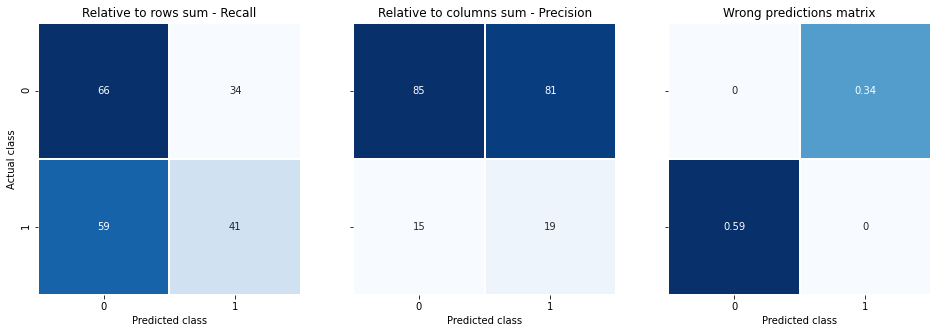

In [21]:
##### Batches structure
y_t_unique, y_t_counts = np.unique(data.y_train, return_counts=True)
y_v_unique, y_v_counts = np.unique(data.y_test, return_counts=True)

# Predictions
predictions = model.predict(data.X_test)
predictions2 = np.array([1 if (prediction > .5) else 0 for prediction in predictions])

##### Confusion Matrix
cm = metrics.confusion_matrix(data.y_test, predictions2)

##### Precision metrics
accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
precision = cm[1][1] / (cm[1][1] + cm[0][1])
recall = cm[1][1] / (cm[1][1] + cm[1][0])
f1_score = 2 * ((precision * recall) / (precision + recall))

##### Roc curve
precisions, recalls, thresholds = metrics.precision_recall_curve(data.y_test, predictions, pos_label = 1)

##### Visualization
print("Train structure:", dict(zip(y_t_unique, y_t_counts / len(data.y_train))))
print("Validation structure:", dict(zip(y_v_unique, y_v_counts / len(data.y_test))))
print()
print("#" * 50)
print("Confusion matrix:\n")
print(cm)
print("#" * 50)
print(">Accuracy:", accuracy)
print(">Precision:", precision)
print(">Recall:", recall)
print(">F1 Score:", f1_score)
print()
print()

# This is to calculate where the wrong predictions go in every column
row_sums = cm.sum(axis = 1, keepdims = True)    # rows sums
column_sums = cm.sum(axis = 0, keepdims = True)    # columns sums
norm_cm = cm / row_sums                         # Division by the column sum
np.fill_diagonal(norm_cm, 0)                    # Fill the diagonal with 0s

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 5), sharey = True)

sns.heatmap(cm / row_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax1, cbar = False)
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
ax1.set_title("Relative to rows sum - Recall")
sns.heatmap(cm / column_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax2, cbar = False)
ax2.set_xlabel("Predicted class")
ax2.set_title("Relative to columns sum - Precision")
sns.heatmap(norm_cm, annot = True, linewidths = .1, cmap = "Blues", ax = ax3, cbar = False)
ax3.set_xlabel("Predicted class")
ax3.set_title("Wrong predictions matrix")

plt.show()

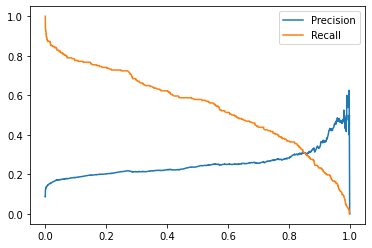

In [24]:
plt.plot(thresholds, precisions[:-1], label = "Precision")
plt.plot(thresholds, recalls[:-1], label = "Recall")
plt.legend()